In [ ]:
!pip install langgraph langchain-core langchain typing_extensions pydantic rich google-generativeai graphviz langchain-google-genai


In [ ]:
!pip install google-genai

In [ ]:
# Imports & Setup
import os, json, operator, getpass
from datetime import datetime
from typing_extensions import Optional, Annotated, Sequence, Literal
from pydantic import BaseModel, Field

from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from rich.markdown import Markdown

console = Console()

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command
from langgraph.checkpoint.memory import InMemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display

import google.generativeai as genai
from getpass import getpass

# Enter API key securely
os.environ["GOOGLE_API_KEY"] = getpass("Enter your Google API Key: ")

# Configure the library
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Initialize the model
model = genai.GenerativeModel("gemini-1.5-flash")


In [5]:
# UI Helper Functions
def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """Nicely display prompts with highlighting."""
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")
    console.print(Panel(formatted_text, title=f"[bold green]{title}[/bold green]", border_style=border_style, padding=(1,2)))

def format_message_content(message):
    parts, tool_calls_processed = [], False
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))
    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")
            parts.append(f"   ID: {tool_call['id']}")
    return "\n".join(parts)

def format_messages(messages):
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message','')
        content = format_message_content(m)
        if msg_type == 'Human':
            console.print(Panel(content, title="Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"{msg_type}", border_style="white"))

In [6]:
# Prompt Templates
clarify_with_user_instructions = """
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.

Return JSON with:
- "{{\"need_clarification\"}}": true/false
- "{{\"question\"}}": string (if clarification needed)
- "{{\"verification\"}}": string (if enough info)
"""

In [7]:
# State & Schemas
class AgentInputState(MessagesState): pass

class AgentState(MessagesState):
    research_brief: Optional[str]
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: str

class ClarifyWithUser(BaseModel):
    need_clarification: bool
    question: str
    verification: str

class ResearchQuestion(BaseModel):
    research_brief: str


In [8]:
# Utilities
def get_today_str() -> str:
    dt = datetime.now()
    return f"{dt.strftime('%a %b')} {dt.day}, {dt.strftime('%Y')}"


In [13]:
# Workflow Nodes
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    import re, json

    prompt = f"""
    These are the messages that have been exchanged so far from the user asking for the report:
    <Messages>
    {get_buffer_string(messages=state['messages'])}
    </Messages>

    Today's date is {get_today_str()}.

    Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.

    Return JSON with:
    {{
      "need_clarification": true/false,
      "question": "...",
      "verification": "..."
    }}
    """

    response = model.generate_content(contents=prompt)
    output_text = response.text

    match = re.search(r"\{.*\}", output_text, re.DOTALL)
    if match:
        try:
            parsed = json.loads(match.group())
        except json.JSONDecodeError:
            return Command(goto=END, update={"messages":[AIMessage(content="Clarification step failed (JSON decode error).")]})
    else:
        return Command(goto=END, update={"messages":[AIMessage(content="Clarification step failed (No JSON found).")]})

    if parsed.get("need_clarification"):
        return Command(goto=END, update={"messages":[AIMessage(content=parsed.get("question", "Need clarification"))]})
    else:
        return Command(goto="write_research_brief", update={"messages":[AIMessage(content=parsed.get("verification", "Proceeding with research brief"))]})

def write_research_brief(state: AgentState) -> Command[Literal["__end__"]]:
    import re, json

    user_topic = state['messages'][-1].content  # last user input

    prompt = f"""
    You are a research assistant. Write a research brief about the following topic: {user_topic}.
    Return only valid JSON in the format:
    {{
      "date": "{get_today_str()}",
      "title": "...",
      "problem_statement": "...",
      "key_questions": ["...", "...", "..."],
      "potential_sources": ["...", "...", "..."]
    }}
    """

    response = model.generate_content(contents=prompt)
    output_text = response.text

    match = re.search(r"\{.*\}", output_text, re.DOTALL)
    if match:
        try:
            parsed = json.loads(match.group())

            # Always make sure date is included at the top
            parsed = {
                "date": get_today_str(),
                "title": parsed.get("title", ""),
                "problem_statement": parsed.get("problem_statement", ""),
                "key_questions": parsed.get("key_questions", []),
                "potential_sources": parsed.get("potential_sources", [])
            }

            return Command(
                goto=END,
                update={
                    "research_brief": json.dumps(parsed, indent=2),
                    "messages": [AIMessage(content="Research brief generated successfully ")]
                }
            )
        except json.JSONDecodeError:
            return Command(goto=END, update={"messages":[AIMessage(content="Error: Failed to parse JSON")]})
    else:
        return Command(goto=END, update={"messages":[AIMessage(content="Error: No JSON found in response")]})



In [14]:
# Graph Build
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)

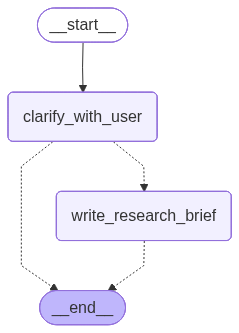

In [15]:
# Visualize workflow
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [17]:
# Interactive Demo with Rich Panel
import json
from IPython.display import display, Markdown
from datetime import datetime

# Interactive Demo
while True:
    user_topic = input("\nEnter your research topic (or type 'exit' to quit): ")
    if user_topic.lower() == "exit":
        break

    thread = {"configurable": {"thread_id": "1"}}
    result = scope.invoke({"messages":[HumanMessage(content=user_topic)]}, config=thread)

    format_messages(result['messages'])

    if "research_brief" in result:
        # Parse JSON
        brief_json = json.loads(result["research_brief"])

        # Extract fields
        title = brief_json.get("title", "Untitled")
        problem = brief_json.get("problem_statement", "N/A")
        questions = brief_json.get("key_questions", [])
        sources = brief_json.get("sources", [])

        # Today’s date
        today = datetime.today().strftime("%Y-%m-%d")

        # -------- View 1: Pretty JSON --------
        formatted_json = json.dumps(brief_json, indent=2)
        display(Markdown(f"**Date:** {today}\n\n### Raw JSON Research Brief\n```json\n{formatted_json}\n```"))

        # -------- View 2: Clean Markdown Report --------
        md_output = f"""
**Date:** {today}

### Research Brief: {title}

**Problem Statement**
{problem}

**Key Questions**
"""
        for q in questions:
            md_output += f"- {q}\n"

        md_output += "\n**Sources**\n"
        for s in sources:
            md_output += f"- {s}\n"

        display(Markdown(md_output))


╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ Aritficial Intelligence                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Could you please clarify what kind of report you need on Artificial Intelligence?  For example, are you         │
│ interested in a market analysis, a technological overview, ethical considerations, or something else?           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ ethical considerations                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Regarding the ethical considerations of Artificial Intelligence, could you please specify which aspects are of  │
│ most interest?  For example, are you interested in bias in algorithms, job displacement, autonomous weapons,    │
│ privacy concerns, or a broader overview?                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ autonomous vehicles                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Regarding autonomous vehicles, what specific ethical considerations are you most interested in? For example,    │
│ are you interested in liability in accidents, the ethical implications of programming moral decision-making in  │
│ self-driving cars,  the impact on employment in the transportation sector, or data privacy related to vehicle   │
│ operation and location?                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ just give me a general overview                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Regarding the ethical considerations of autonomous vehicles,  should the overview focus on specific             │
│ applications (e.g., passenger cars, trucking) or provide a broader overview encompassing all types of           │
│ autonomous vehicles?                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ provide a broader overview encompassing all types of           │ │ autonomous vehicles?                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ The user has sufficiently narrowed down their request to a general overview of the ethical considerations of    │
│ all types of autonomous vehicles.  No further clarifying questions are needed before beginning research.        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Research brief generated successfully                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ Artificial Intelligence                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ The conversation log shows the AI successfully guided the user to specify their request to 'a general overview  │
│ of the ethical considerations of all types of autonomous vehicles'. The AI explicitly stated that no further    │
│ clarifying questions are needed before beginning research.  The final user message 'Artificial Intelligence'    │
│ appears to be unrelated and can be ignored as it's a repetition of an earlier topic.                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Research brief generated successfully                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**Date:** 2025-09-09

### Raw JSON Research Brief
```json
{
  "date": "Tue Sep 9, 2025",
  "title": "Ethical Considerations of Autonomous Vehicles: A General Overview",
  "problem_statement": "To comprehensively analyze and synthesize the ethical considerations surrounding the development, deployment, and use of all types of autonomous vehicles (AVs), encompassing various technological approaches and operational contexts.",
  "key_questions": [
    "What are the primary ethical dilemmas posed by the potential for accidents and harm caused by AVs, including issues of liability, responsibility, and algorithmic bias?",
    "How do different ethical frameworks (e.g., utilitarianism, deontology, virtue ethics) inform the design and regulation of AVs, particularly regarding decision-making algorithms and safety protocols?",
    "What are the societal and economic implications of widespread AV adoption, including impacts on employment, accessibility, and social equity, and how can these be ethically addressed?",
    "What are the legal and regulatory challenges in establishing clear lines of accountability and responsibility for AV accidents and malfunctions, and how can ethical principles be integrated into legal frameworks?",
    "How can ethical considerations be effectively integrated into the design, testing, and deployment processes of AVs to ensure responsible innovation and mitigate potential harms?"
  ],
  "potential_sources": [
    "The National Highway Traffic Safety Administration (NHTSA) reports and guidelines on autonomous vehicles",
    "Academic journals and publications on ethics and AI, focusing on autonomous systems (e.g., Science, Nature, Ethics & Information Technology)",
    "Reports and publications from organizations such as the IEEE, ACM, and AAAI on ethical guidelines for AI and robotics",
    "Legal scholarship and case law related to product liability and negligence in the context of autonomous vehicles",
    "Governmental reports and policy documents on autonomous vehicle regulation and safety standards (e.g., from the European Union, the United States, etc.)"
  ]
}
```


**Date:** 2025-09-09

### Research Brief: Ethical Considerations of Autonomous Vehicles: A General Overview

**Problem Statement**  
To comprehensively analyze and synthesize the ethical considerations surrounding the development, deployment, and use of all types of autonomous vehicles (AVs), encompassing various technological approaches and operational contexts.

**Key Questions**
- What are the primary ethical dilemmas posed by the potential for accidents and harm caused by AVs, including issues of liability, responsibility, and algorithmic bias?
- How do different ethical frameworks (e.g., utilitarianism, deontology, virtue ethics) inform the design and regulation of AVs, particularly regarding decision-making algorithms and safety protocols?
- What are the societal and economic implications of widespread AV adoption, including impacts on employment, accessibility, and social equity, and how can these be ethically addressed?
- What are the legal and regulatory challenges in establishing clear lines of accountability and responsibility for AV accidents and malfunctions, and how can ethical principles be integrated into legal frameworks?
- How can ethical considerations be effectively integrated into the design, testing, and deployment processes of AVs to ensure responsible innovation and mitigate potential harms?

**Sources**



Enter your research topic (or type 'exit' to quit): exit
